In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from tqdm import tqdm

from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score

from sentence_transformers import SentenceTransformer, models

import warnings
warnings.filterwarnings(action='ignore')

rcParams['figure.figsize'] = 12, 8

## 네이버 뉴스에서 수집한 뉴스 기사들 데이터 불러오기

In [2]:
df = pd.read_csv('new_naver_news.csv', encoding='utf-8')
df.columns = ['link', 'title', 'date', 'text']
df = df.drop_duplicates('link').reset_index(drop=True)
print(df.shape)
df.head()

(6589, 4)


,link,title,date,text
0,https://n.news.naver.com/mnews/article/648/000...,"클레이튼, 카카오와 '헤어질 결심'",2023.03.06.,"클레이튼, 간담회 열고 올해의 '비전 맵' 발표클레이 사용처 늘리고 투명한 정보 공..."
1,https://n.news.naver.com/mnews/article/421/000...,"카카오 벗어난 클레이튼, 올해 '대중화'에 중점…'디플레이션' 추구(종합)",2023.03.06.,"자체 코인 '클레이' 디플레이션 추구…""클레이 활용처 늘릴 것""""카카오 '거리두기'..."
2,https://n.news.naver.com/mnews/article/008/000...,"경기도, 학생과 기업이 만나는 진로 체험 참여 기업 모집",2023.03.06.,경기도가 '학생과 기업이 만나는 경기도 진로 체험'에 참여할 기업을 내달 7일까지 ...
3,https://n.news.naver.com/mnews/article/009/000...,"롯데홈쇼핑 NFT 프로젝트 ‘벨리곰 NFT’, 협업사부터 메인넷까지 전면 개편 발표...",2023.03.06.,[엠블록레터] 롯데홈쇼핑의 NFT 프로젝트 벨리곰 NFT가 시즌2를 맞아 대대적인 ...
4,https://n.news.naver.com/mnews/article/417/000...,"경기도, 학생과 만나는 진로체험 참여기업 모집…4월7일까지",2023.03.06.,경기도청 광교청사 전경. / 사진제공=경기도 경기도가 '학생과 기업이 만나는 경기도...


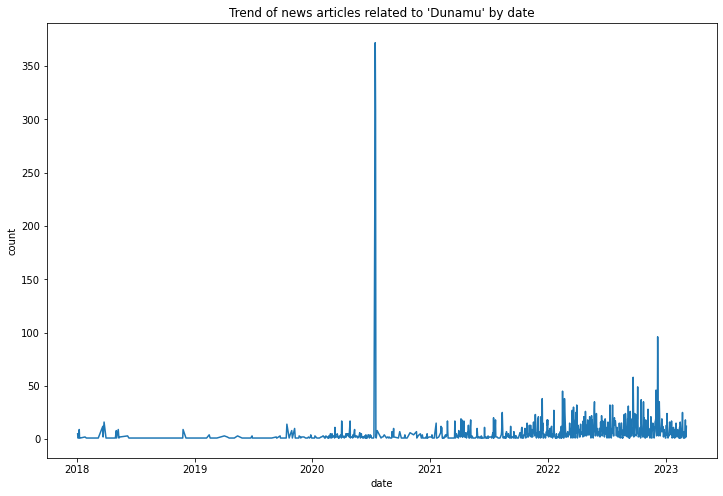

In [39]:
df['date'] = df['date'].astype('str').astype('datetime64[ns]')
count_df = pd.DataFrame(df.value_counts('date')).sort_values('date').reset_index()
count_df['date'] = pd.to_datetime(count_df['date'], format = '%Y-%m-%d')
count_df.columns = ['date', 'count']
count_df = count_df[count_df['date'] >= '2018-01-01']

sns.lineplot(x='date', y='count', data=count_df)
plt.title("Trend of news articles related to 'Dunamu' by date")
plt.show()

2020년 7월 경에 갑작스럽게 뉴스 기사가 많이 발견된 이유를 확인해보니, 두나무 로봇 기자인 C-Biz봇의 글들이 많이 수집되었기 때문.

## 수집한 뉴스 기사의 본문에서 konlpy를 통해 명사만 추출

In [3]:
okt = Okt()
df['nouns'] = ''

# 기사의 제목과 본문 텍스트에 대해 2글자 이상의 명사만을 추출해서 새로운 column 만들기
for i, _ in tqdm(df.iterrows()):
    nouns = okt.nouns(df.loc[i, 'title'] + ' ' + df.loc[i, 'text'])
    final_nouns = list(filter(lambda x: len(x) >= 2, nouns))
    df.loc[i, 'nouns'] = final_nouns
    
print(df.shape)
df.head()

6589it [05:45, 19.06it/s]

(6589, 5)


,link,title,date,text,nouns
0,https://n.news.naver.com/mnews/article/648/000...,"클레이튼, 카카오와 '헤어질 결심'",2023.03.06.,"클레이튼, 간담회 열고 올해의 '비전 맵' 발표클레이 사용처 늘리고 투명한 정보 공...","[클레이튼, 카카오, 결심, 클레이튼, 간담, 올해, 발표, 클레이, 사용, 정보,..."
1,https://n.news.naver.com/mnews/article/421/000...,"카카오 벗어난 클레이튼, 올해 '대중화'에 중점…'디플레이션' 추구(종합)",2023.03.06.,"자체 코인 '클레이' 디플레이션 추구…""클레이 활용처 늘릴 것""""카카오 '거리두기'...","[카카오, 클레이튼, 올해, 대중화, 중점, 디플레이션, 추구, 종합, 자체, 코인..."
2,https://n.news.naver.com/mnews/article/008/000...,"경기도, 학생과 기업이 만나는 진로 체험 참여 기업 모집",2023.03.06.,경기도가 '학생과 기업이 만나는 경기도 진로 체험'에 참여할 기업을 내달 7일까지 ...,"[경기도, 학생, 기업, 진로, 체험, 참여, 기업, 모집, 경기도, 학생, 기업,..."
3,https://n.news.naver.com/mnews/article/009/000...,"롯데홈쇼핑 NFT 프로젝트 ‘벨리곰 NFT’, 협업사부터 메인넷까지 전면 개편 발표...",2023.03.06.,[엠블록레터] 롯데홈쇼핑의 NFT 프로젝트 벨리곰 NFT가 시즌2를 맞아 대대적인 ...,"[롯데, 홈쇼핑, 프로젝트, 협업, 메인넷, 전면, 개편, 발표, 블록, 레터, 블..."
4,https://n.news.naver.com/mnews/article/417/000...,"경기도, 학생과 만나는 진로체험 참여기업 모집…4월7일까지",2023.03.06.,경기도청 광교청사 전경. / 사진제공=경기도 경기도가 '학생과 기업이 만나는 경기도...,"[경기도, 학생, 진로, 체험, 참여, 기업, 모집, 경기, 도청, 광교, 청사, ..."


In [4]:
# 문서를 명사 집합으로 보고 문서 리스트로 치환 (tfidfVectorizer 인풋 형태를 맞추기 위해)
text = [" ".join(noun) for noun in df['nouns']]

tfidf_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1, 5))
tfidf_vectorizer.fit(text)
vector = tfidf_vectorizer.transform(text).toarray()

## 1. 뉴스 기사 본문의 명사 형태 단어들의 TF-IDF로 군집 (DBSCAN)

In [5]:
### Clustering - DBSCAN
vector = np.array(vector) # Normalizer를 이용해 변환된 벡터
model = DBSCAN(eps=0.5, min_samples=5, metric = "cosine")
result = model.fit_predict(vector)
df['dbscan_cluster'] = result
df.value_counts('dbscan_cluster')

dbscan_cluster
-1      2592
 176     803
 1       234
 85      107
 26       67
        ... 
 231       5
 233       5
 33        5
 30        5
 146       5
Length: 263, dtype: int64

## 2. 뉴스 기사 본문의 명사 형태 단어들의 TF-IDF로 군집 (K-means)

100%|███████████████████████████████████████| 28/28 [8:39:31<00:00, 1113.28s/it]


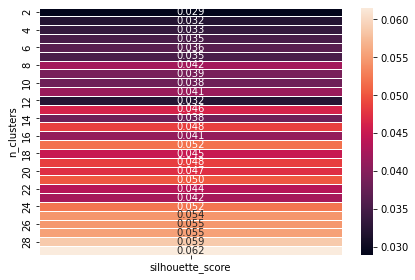

kmeans_cluster
21    929
1     708
5     491
8     481
27    440
17    396
16    342
18    325
25    323
4     252
22    234
24    177
23    158
10    126
13    124
19    124
6     123
26    123
11     95
14     94
9      91
2      85
28     80
3      76
20     72
7      47
15     45
0      16
12     12
dtype: int64

In [7]:
### Clustering - K-means
def visualize_silhouette_layer(data):
    clusters_range = range(2, 30)
    results = []

    for i in tqdm(clusters_range):
        clusterer = KMeans(n_clusters=i)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame( results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()
    
    return result

result = visualize_silhouette_layer(vector) # 가장 높은 실루엣 계수와 매핑되는 k
best_cluster = result.sort_values('silhouette_score').tail(1)['n_clusters'].values[0]
df['kmeans_cluster'] = KMeans(n_clusters=best_cluster).fit_predict(vector)
df.value_counts('kmeans_cluster')

## 3. 뉴스 기사 본문으로 군집 (SBERT 모델)

In [8]:
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

corpus_embeddings = model.encode(df['text'])
clustering_model = KMeans(n_clusters=best_cluster) # k = 29
clustering_model.fit(corpus_embeddings)
df['sbert_kmeans_cluster'] = clustering_model.labels_
df.value_counts('sbert_kmeans_cluster')

sbert_kmeans_cluster
9     413
2     382
3     372
15    348
5     344
17    329
22    320
6     310
1     308
0     275
19    269
23    257
11    256
4     233
14    226
13    203
7     200
21    192
12    168
16    156
20    154
25    147
27    139
28    139
24    138
26    111
18     90
10     81
8      29
dtype: int64

## SBERT를 통해 군집화 (k=29) 결과에 따라 가장 많이 나왔던 명사와 본문을 보며 키워드를 출력해보기

1. Cluster 0: `코인의 부정적 전망에 대한 군집` => 코인, 하락, 공포탐욕지수, 투자 심리 위축, 불안
2. Cluster 1: `두나무의 성과에 대한 군집` => ISMS-P 인증 획득, 블록체인 산업 육성, 스타트업 투자, 컨퍼런스, 대학생 서포터즈, 지수 개발
3. Cluster 2: `두나무 로봇 기자인 C-Biz봇의 기사 (개별 주식)에 대한 군집` => 상승, 외국인, 기관, 주가, 거래, VI 발동
4. Cluster 3: `두나무 로봇 기자인 C-Biz봇의 기사 (연관 테마 소개)에 대한 군집` => 상승, 외국인, 기관, 주가, 거래, 연관, 테마
5. Cluster 4: `오늘의 코인 가격 분석에 대한 군집` => 코인, 상승, 하락, 지수, 시장, 전망
6. Cluster 5: `스타트업 분석에 대한 군집` => 카카오, 쏘카, 당근마켓, 스타트업, NFT, 블록체인, 메타버스, IPO, 비상장
7. Cluster 6: `두나무 및 카카오 관련 내용에 대한 군집` => 카카오, 두나무, 투자, 비상장, 주식, 기업
8. Cluster 7: `두나무의 ESG 관련 행보에 대한 군집` => 투자자 보호 센터, ESG 경영위, 사회, 환경, 투자, 후원, 기부
9. Cluster 8: `두나무 한국프로탁구리그에 대한 군집` => 탁구, 경기, 리그, 선수
10. Cluster 9: `암호화폐 전망 및 이슈에 대한 군집` => 가상자산, 거래소, 코인, 투자자, 시장, 대표, 루나코인, 테라코인
11. Cluster 10: `두나무 매출에 대한 군집` => 두나무, 영업, 매출, 이익, 순이익, 투자, 기록, 증가, 감소
12. Cluster 11: `두나무의 NFT 활용 사례에 대한 군집` => NFT, 작품, 토큰, 거래, 작가, 판매, 기부, 전시, 이벤트
13. Cluster 12: `두나무 로봇 기자인 C-Biz봇의 기사 (ETF 가격 변화)에 대한 군집` => 선물, 지수, 코스닥, 코스피, 원유, 레버리지, 추종, ETF
14. Cluster 13: `두나무의 사회 활동에 대한 군집` => 청년, 지원, 교육, 금융, 프로그램, 자립, 사업
15. Cluster 14: `두나무의 사업 전망에 대한 군집` => 블록체인, 대표, 행사, 개발자, 컨퍼런스, UDC 2022, 람다256 
16. Cluster 15: `코인 가격에 대한 군집` => 비트코인, 가상화폐, 가격, 지수, 거래, 투자
17. Cluster 16: `두나무 로봇 기자인 C-Biz봇의 기사 (강세 토픽)에 대한 군집` => 테마, 종목, 산업, 등락, 기업, 투자
18. Cluster 17: `스타트업 투자에 대한 군집` => 카카오, 스타트업, 투자, 기업, 사업, 시장, 창업
19. Cluster 18: `두나무 법적 이슈에 대한 군집` => 무죄, 송치, 재판, 검찰, 선고, 혐의, 영장, 증거
20. Cluster 19: `두나무의 자회사에 대한 군집` => 람다256, 메타버스, 블록체인, 사업, 웹 3.0 시대
21. Cluster 20: `스타트업 일자리 등과 관련한 군집` => 고용, 일자리, 유니콘, 스타트업, 투자, 성장
22. Cluster 21: `주식 가격 상승 및 하락에 대한 군집` => 투자, 거래, 상승, 주가, 시장, 하락, 종목
23. Cluster 22: `기업 전망에 대한 군집` => 기업, 회사, 거래, 시장, 사업, 정부, 대기업
24. Cluster 23: `증권플러스에 대한 군집` => 증권플러스, 비상장, 투자, 서비스, 주식, 자산, 기업, 정보, 플랫폼, 종목, 투자자, 관리
25. Cluster 24: `하이브-두나무 관련 군집` => 하이브, 사업, 아티스트, 메타버스, 엔터테인먼트, 콘텐츠, 매출, 주가, 시장, 팬덤
26. Cluster 25: `국감 출석에 대한 군집` => 카카오, 증인, 정무, 국회, 국감, 출석, 국정감사
27. Cluster 26: `두나무 로봇 기자인 C-Biz봇의 기사에 대한 군집` => 상승, 주가, 기관, 전일, 대비, 거래, 테마
28. Cluster 27: `두나무의 환경 관련 활동에 대한 군집` => 두나무, 산림, 캠페인, 피해, 산림청, 식물, 포레스트, 조성
29. Cluster 28: `암호화폐 상장 폐지와 관련한 군집` => 위믹스, 위메이드, 거래소, 상장폐지, 가처분, 자산

In [84]:
cluster_df = df.groupby('sbert_kmeans_cluster').agg({'nouns': 'sum'}).reset_index()
cluster_df.columns = ['cluster', 'nouns']

for i, _ in cluster_df.iterrows():
    print(f"Cluster: {i}")
    print(Counter(cluster_df[cluster_df['cluster'] == i]['nouns'][i]).most_common(10), '\n')

Cluster: 0
[('코인', 1711), ('가상', 1691), ('비트코인', 1566), ('자산', 1525), ('시장', 1496), ('화폐', 1235), ('지수', 1179), ('공포', 1112), ('하락', 1051), ('거래소', 918)] 

Cluster: 1
[('자산', 1643), ('비트', 1393), ('나무', 1322), ('디지털', 1153), ('지수', 774), ('인덱스', 683), ('시장', 654), ('투자자', 643), ('투자', 635), ('금융', 628)] 

Cluster: 2
[('상승', 998), ('조선', 773), ('외국인', 764), ('기관', 764), ('주가', 764), ('비즈', 764), ('확대', 404), ('플러스', 391), ('증권', 388), ('거래', 382)] 

Cluster: 3
[('상승', 935), ('비즈', 744), ('조선', 743), ('외국인', 742), ('기관', 742), ('주가', 742), ('테크', 556), ('플러스', 428), ('에스', 406), ('전자', 401)] 

Cluster: 4
[('시장', 1500), ('지수', 1068), ('화폐', 942), ('암호', 877), ('공포', 786), ('탐욕', 725), ('하락', 561), ('코인', 494), ('매우', 462), ('갈수록', 440)] 

Cluster: 5
[('투자', 2922), ('거래', 2006), ('기업', 1848), ('증권', 1755), ('비상', 1718), ('시장', 1696), ('주식', 1538), ('자산', 1498), ('가상', 1356), ('플랫폼', 1155)] 

Cluster: 6
[('나무', 1594), ('증권', 1293), ('투자', 1279), ('거래', 1167), ('비상', 1050), ('주식', 889), ('카카

## 위 결과에서 비슷한 항목들이 존재 했기에, 군집의 숫자를 변경해보기 (k = 29 -> 12)

1. 두나무 매출에 관한 군집 (군집 10)
2. 두나무 한국프로탁구리그에 대한 군집 (군집 8)
3. 암호화폐 상장 폐지와 관련한 군집 (군집 28)
4. 주식 가격 상승 및 하락에 대한 군집 (군집 21)
5. 기업 전망에 대한 군집 (군집 22)
6. 하이브-두나무에 대한 군집 (군집 24)
7. 스타트업 일자리 등과 관련한 군집 (군집 5, 20)
8. 스타트업 투자 및 카카오 관련 군집 (군집 6, 17)
9. 두나무 법적 이슈 및 국감 출석에 관한 군집 (군집 18, 25)
10. 코인 가격 전망과 관련한 군집 (군집 0, 4, 9, 15)
11. 두나무 로봇 기자인 C-Biz봇의 기사에 대한 군집 (군집 2, 3, 12, 16, 26)
12. 두나무 성과 및 사회적 활동에 대한 군집 (군집 1, 7, 11, 13, 14, 19, 23, 27)

In [85]:
corpus_embeddings = model.encode(df['text'])
new_clustering_model = KMeans(n_clusters=12) # k = 12
new_clustering_model.fit(corpus_embeddings)
df['sbert_kmeans_new_cluster'] = new_clustering_model.labels_
df.value_counts('sbert_kmeans_new_cluster')

sbert_kmeans_new_cluster
9     866
5     838
0     790
8     684
11    670
3     533
4     532
10    477
1     392
7     321
2     317
6     169
dtype: int64

In [89]:
df.sort_values('sbert_kmeans_new_cluster').to_csv('/Users/paul/Desktop/df.csv')

## 군집 개수 수정 후, 다시 군집 세부 분류 추론

1. Cluster 0: `스타트업 및 비상장 주식에 대한 군집` => 스타트업, 투자, 비상장, 주식, 증권플러스
2. Cluster 1: `두나무 로봇 기자인 C-Biz봇의 기사에 대한 군집` => 상승, 외국인, 기관, 주가, 거래, 대비
3. Cluster 2: `두나무의 사회적 활동에 대한 군집` => 지원, 청년, 사회, 교육, 기부, 자립, 아동
4. Cluster 3: `주식 가격 전망에 대한 군집` => 투자, 기업, 종목, 사업, 거래, 테마, 매출, 상승, 시장
5. Cluster 4: `법적 이슈 및 국감 출석에 대한 군집` => 국회, 증인, 대표, 회장, 국감, 
6. Cluster 5: `암호화폐 가격 전망에 대한 군집` => 시장, 비트코인, 화폐, 지수, 코인, 탐욕, 공포, 거래, 가격
7. Cluster 6: `강세 토픽 분석에 대한 군집` => 선물, 지수, 코스닥, 원유, 수익률, 레버리지, 추종, ETF
8. Cluster 7: `두나무의 환경 활동에 대한 군집` => 산림, 캠페인, 산림청, 사회, 기부, ESG
9. Cluster 8: `두나무 사업에 대한 군집` => 증권플러스, 업비트, 비상장, 두나무투자일임, UBCI, 지수
10. Cluster 9: `두나무 회사와 협업에 대한 군집` => NFT, 개발자 컨퍼런스, 람다256, 하이브, 
11. Cluster 10: `두나무 로봇 기자인 C-Biz봇의 기사 (연관 테마)에 대한 군집` => 상승, 외국인, 기관, 주가, 증권플러스, 거래, 연관, 테마
12. Cluster 11: `안전한 암호화폐 거래에 대한 군집` => 거래소, 투자자, 위믹스, 루나, 테라, 상장폐지

In [90]:
cluster_df = df.groupby('sbert_kmeans_new_cluster').agg({'nouns': 'sum'}).reset_index()
cluster_df.columns = ['cluster', 'nouns']

for i, _ in cluster_df.iterrows():
    print(f"Cluster: {i}")
    print(Counter(cluster_df[cluster_df['cluster'] == i]['nouns'][i]).most_common(20), '\n')

Cluster: 0
[('투자', 6777), ('기업', 4793), ('거래', 2773), ('시장', 2770), ('증권', 2423), ('나무', 2410), ('비상', 2302), ('주식', 2114), ('스타트업', 2066), ('플랫폼', 2050), ('자산', 2024), ('사업', 1964), ('카카오', 1936), ('상장', 1889), ('가상', 1658), ('서비스', 1642), ('국내', 1566), ('대표', 1479), ('유니콘', 1468), ('거래소', 1358)] 

Cluster: 1
[('상승', 1037), ('외국인', 796), ('기관', 791), ('조선', 788), ('주가', 775), ('비즈', 774), ('거래', 413), ('확대', 408), ('증권', 400), ('대비', 396), ('플러스', 395), ('기자', 395), ('나무', 393), ('전일', 391), ('등락', 391), ('네이버', 390), ('최근', 389), ('메인', 389), ('매매', 388), ('보기', 388)] 

Cluster: 2
[('나무', 2416), ('지원', 1241), ('청년', 775), ('사회', 688), ('금융', 687), ('기업', 665), ('교육', 661), ('위해', 584), ('디지털', 574), ('사업', 500), ('기부', 500), ('자산', 488), ('자립', 442), ('비트', 402), ('통해', 395), ('대표', 391), ('제공', 384), ('아동', 362), ('블록', 359), ('청소년', 354)] 

Cluster: 3
[('투자', 1613), ('증권', 1386), ('나무', 1352), ('기업', 1204), ('종목', 1014), ('사업', 1009), ('거래', 953), ('테마', 914), ('매출', 884), ('대비', 8

In [86]:
df.to_csv('new_naver_news_clustering.csv')